# Analyzing Beacon Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import urllib
import os
import copy

In [2]:
dir_path = 'ftp://data.munroelab.ca/pub/iceberg/beacon/'
dir_contents = urllib.request.urlopen(dir_path).read().splitlines()
filenames = [str(listing.split()[-1])[2:-1] for listing in dir_contents]
csv_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('csv')]
kml_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('kml')]
metadata_filename = filenames[-1]

In [3]:
beacon_metadata = pd.read_csv(dir_path + metadata_filename)

In [4]:
beacon_metadata

,BeaconID,IMEI,ArgosID,WMO,DataOwner,DataSharingRestrictions,Contact,BeaconType,Manufacturer,Transmitter,...,RelatedBeaconIDs,AdditionalDatasets,Project,Photos_Y_N,NumberPhotos,PhotoCredits,PhotoRestrictions,PhotoComments,PhotoNames,Comments
0,204980,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"906790, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,7,"Derek Mueller, Anna Crawford",4,NaN,"204980_2015_approaching the saddle berg 1.JPG,...",Beacon deployed during ArcticNet/Statoil/WIRL ...
1,505190,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"907780, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,10,"Derek Mueller, Anna Crawford",4,NaN,"505190_2015_Approaching tabular berg.JPG, 5051...",Beacon deployed during ArcticNet/Statoil/WIRL ...
2,906790,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"204980, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,See 204980,See 204980,4,NaN,see 204980,Beacon deployed during ArcticNet/Statoil/WIRL ...
3,907780,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"505190, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,See 505190,See 505190,4,NaN,see 505190,Beacon deployed during ArcticNet/Statoil/WIRL ...


In [5]:
def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

In [6]:
df = get_df(dir_path, csv_filenames[1])

In [7]:
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,50519,Solara,2015-04-23 18:48:37,NaN,49.22403,-51.25820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50519,Solara,2015-04-23 18:49:07,NaN,49.22401,-51.25817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50519,Solara,2015-04-23 18:49:34,NaN,49.22400,-51.25809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50519,Solara,2015-04-23 18:49:59,NaN,49.22403,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50519,Solara,2015-04-23 18:50:26,NaN,49.22399,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def get_day_idxs(dft, day_inc = 5):

    day_idxs = []
    day_js = []
    day_j = 0
    
    for i in range(len(df)):
        day = (dft[i] - dft[0]).days
        if day == day_j:
            day_idxs.append(i)
            day_js.append(day_j)
            day_j += day_inc
    
    return day_idxs, day_js

In [9]:
def plot_drift_track(df, data_fname):
    
    fig = plt.figure()

    x, y = df['Longitude'], df['Latitude']
    
    plt.scatter(x, y, s=2)
    
    t = df['DataDate_UTC']
    day_idxs, day_js = get_day_idxs(t)
    
    for i, day_idx in enumerate(day_idxs):
    
        plt.text(x[day_idx], y[day_idx], str(day_js[i]), fontsize=16, )
    
    plt.title(f'Drift Track from {data_fname}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig

# Animation

# Simulation

In [10]:
from icedef import constants, iceberg, metocean, drift, tools

In [11]:
def get_iceberg_velocity_from_dataframe(df, start_index, end_index):
    
    dt = (df.DataDate_UTC[end_index] - df.DataDate_UTC[start_index]).total_seconds()  
    dlat = df.Latitude[end_index] - df.Latitude[start_index]
    dlon = df.Longitude[end_index] - df.Longitude[start_index]
    
    mid_lat = (df.Latitude[end_index] + df.Latitude[start_index]) / 2
    
    dy = tools.dlat_to_dy(dlat)
    dx = tools.dlon_to_dx(dlon, mid_lat)
    
    vx = dx/dt
    vy = dy/dt
    
    v = (vx, vy)
    
    return v

In [12]:
csv_filenames

['0204980_2015.csv',
 '0505190_2015.csv',
 '0906790_2015.csv',
 '0907780_2015.csv']

In [13]:
def drift_wrapper(berg_inits, meto, time_info, **kwargs):
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), 
                              velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

    while berg.time < end_time - time_step:
        
        berg.update_history()

        ax, ay = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))

        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        berg_constants['latitude'] = berg.latitude
            
    return berg

In [14]:
def create_ref_berg_from_df(df, start_index, end_index):
    
    start_time = np.datetime64(df.DataDate_UTC[start_index])
    start_latitude = df.Latitude[start_index]
    start_longitude = df.Longitude[start_index]
    
    ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

    for i in range(end_index - start_index + 2):

        if not df.DataDate_UTC[start_index + i] == df.DataDate_UTC[start_index + i + 1]:
            
            ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
            ref_berg.latitude = df.Latitude[start_index + i]
            ref_berg.longitude = df.Longitude[start_index + i]
            ref_berg.update_history()
    
    return ref_berg

In [18]:
df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

ref_berg = create_ref_berg_from_df(df, start_index, end_index)

start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])

meto = metocean.Metocean((start_time, end_time))

start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

time_step = np.timedelta64(360, 's')
#dt = time_step.item().total_seconds(); #nt = int((end_time - start_time) / time_step)
time_info = (time_step, end_time)

In [19]:
berg2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=3, Cw=0.1)
berg3 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=0.1, Cw=5)

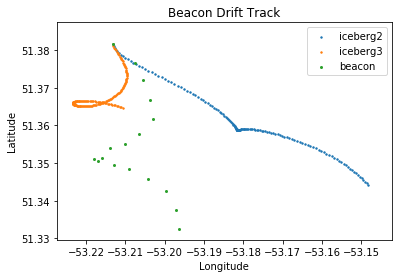

In [20]:
plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='iceberg2')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

# Optimization

In [21]:
from scipy.optimize import minimize

In [22]:
def optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    
    berg = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    try:
        mse = tools.compute_mse((berg.longitude, berg.latitude, berg.time),
                           (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time']),
                           ref_berg.history['time'][0] - np.timedelta64(1,'D'))
    except:
        print(berg2.time)
        raise
    
    return mse
    

In [68]:
def optimization_wrapper2(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    obs_vecs = (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time'])
    reference_time = ref_berg.history['time'][0] - np.timedelta64(1,'D')
    
    berg = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    mse_list = []
    
    for i in range(len(ref_berg.history['time']) - 1):
        
        j = np.where((berg.history['time'] <= ref_berg.history['time'][i + 1]))[0][-1]
        sim_point = (berg.history['longitude'][j], berg.history['latitude'][j], berg.history['time'][j])
        mse = tools.compute_mse(sim_point, obs_vecs, reference_time)
        mse_list.append(mse)
    
    mse = np.mean(np.array(mse_list))
    
    return mse

In [69]:
callback_mses = []
callback_Cas = []
callback_Cws = []

def callback(x):
    
    result = optimization_wrapper(x, ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info)
    callback_mses.append(result)
    callback_Cas.append(x[0])
    callback_Cws.append(x[1])

# Surface Optimization

In [26]:
Ca_num = 2
Cw_num = 2
Ca_lower_bound = 0.1; Ca_upper_bound = 3
Cw_lower_bound = 1; Cw_upper_bound = 16

scaling = 'lin'

if scaling == 'log':

    Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
    Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

elif scaling == 'lin':
    
    Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
    Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [28]:
%%time

berg_inits = (start_time, start_latitude, start_longitude, start_velocity)

mse_matrix = np.zeros((Ca_num, Cw_num))

for i in range(Ca_num):
    for j in range(Cw_num):
        form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
        mse_matrix[i][j] = optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info)
        

CPU times: user 1.4 s, sys: 442 µs, total: 1.4 s
Wall time: 1.4 s


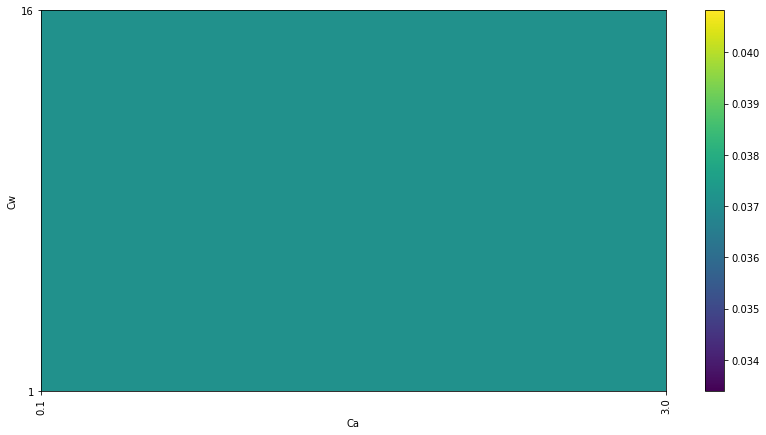

In [30]:
fig = plt.figure(figsize=(14,7))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.colorbar()

plt.show()

In [31]:
optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.026173672167019216
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.09793074e-06, -1.59590743e-04])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 132
      nit: 17
   status: 0
  success: True
        x: array([ 2.1752873, 15.       ])

# Multi-step surface optimization

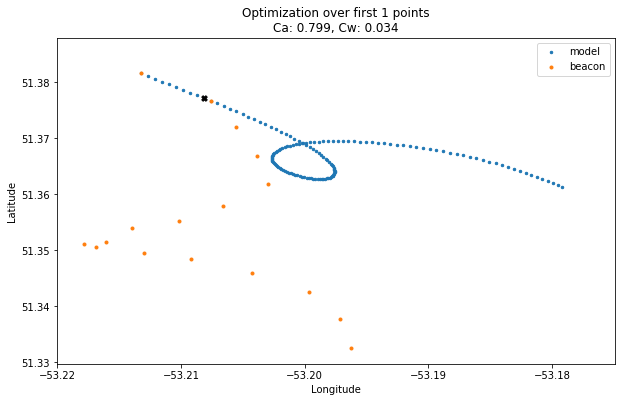

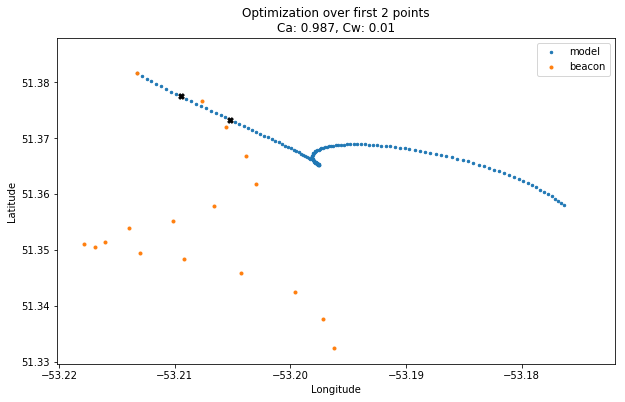

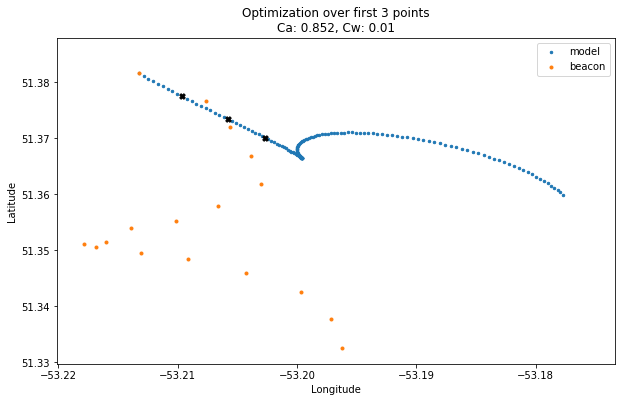

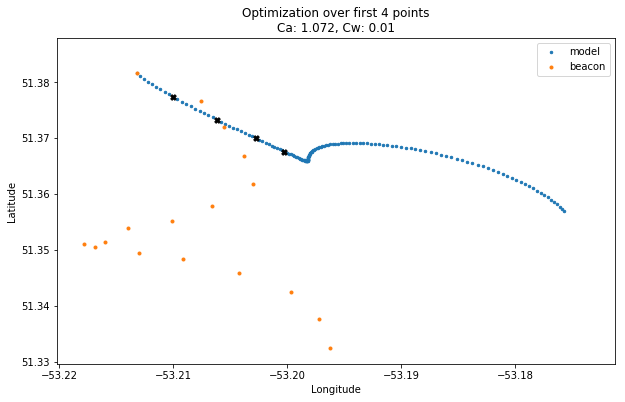

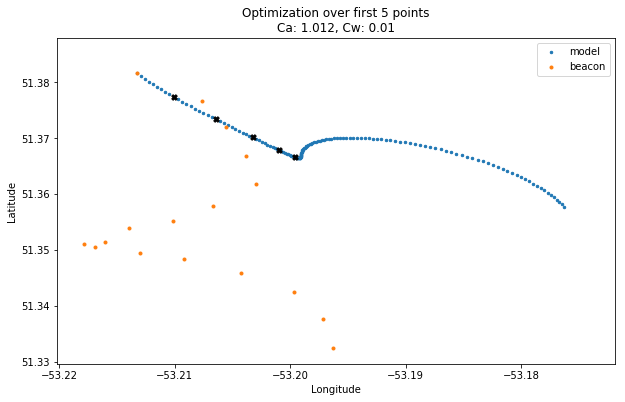

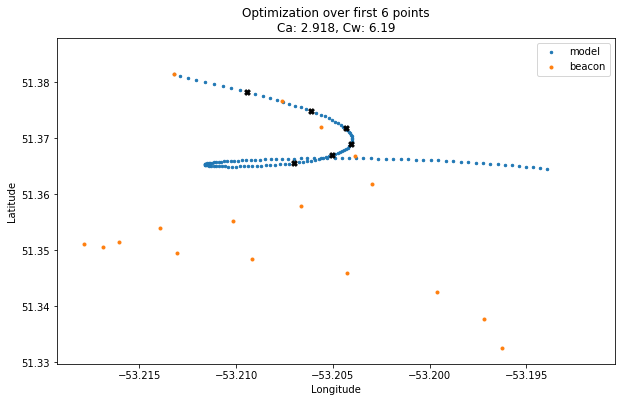

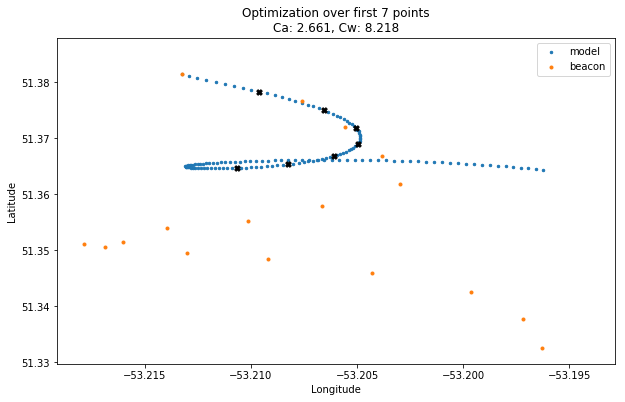

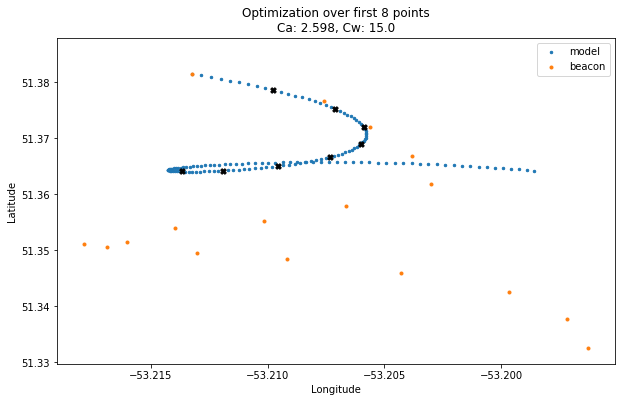

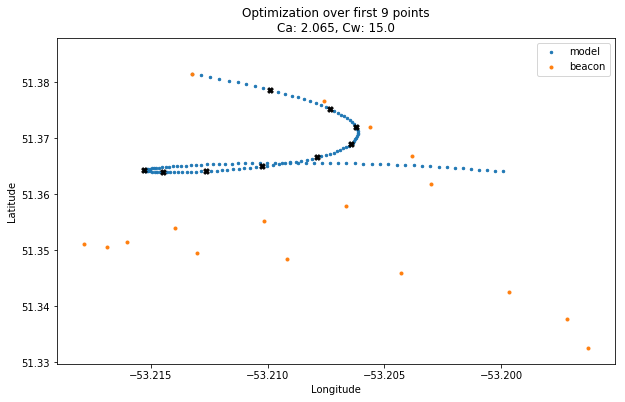

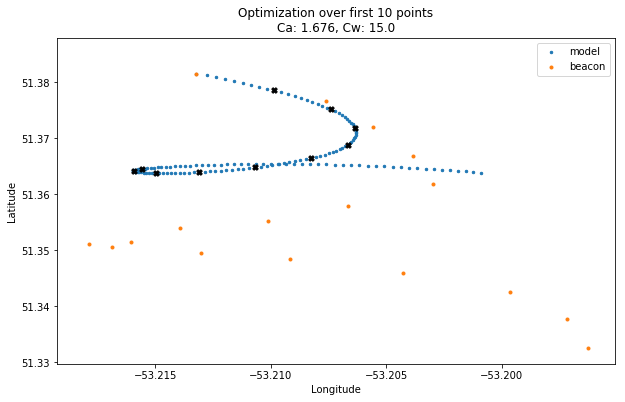

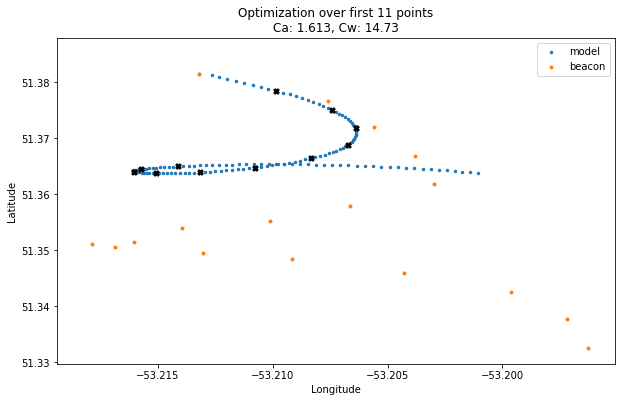

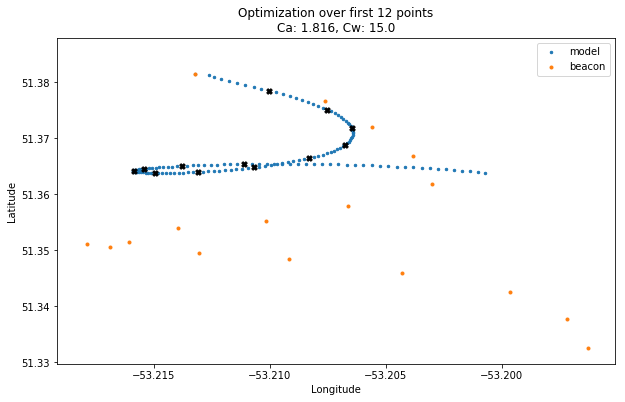

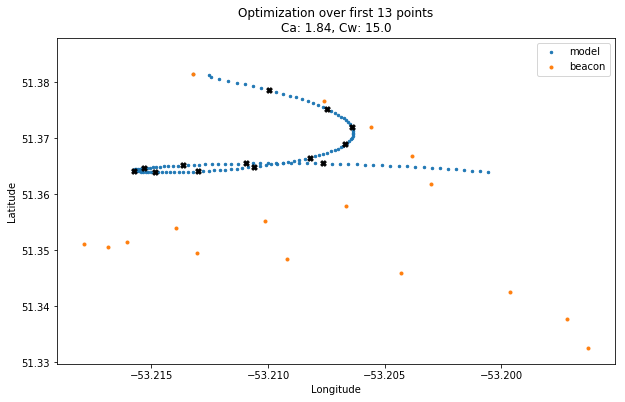

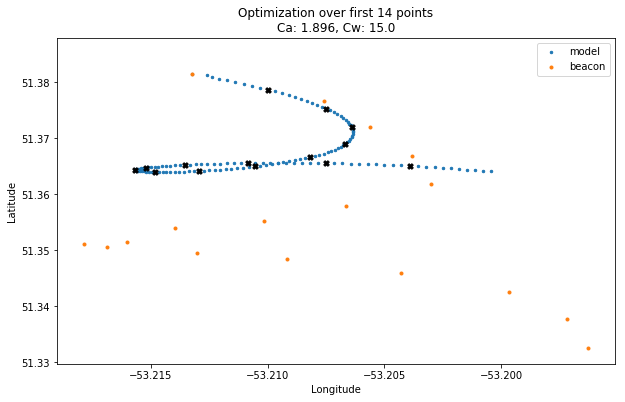

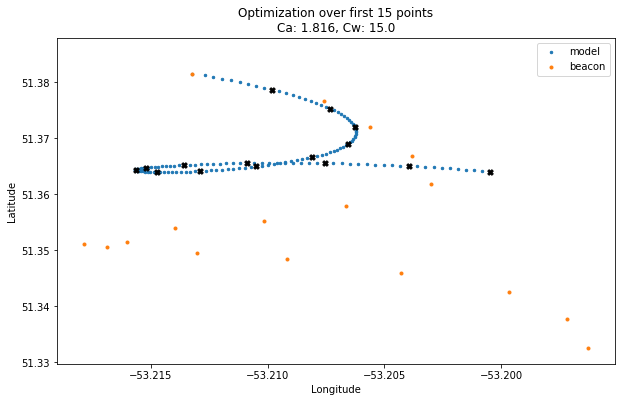

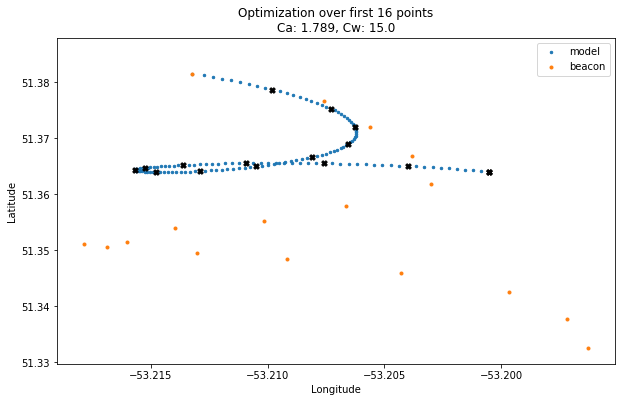

In [106]:
with PdfPages('plots/optim_steps.pdf') as pdf:

    for indxf in range(1, len(ref_berg.history['time'])):

        indxi = 0
        indxf = indxf

        sub_ref_berg = copy.deepcopy(ref_berg)
        sub_ref_berg.history['time'] = sub_ref_berg.history['time'][indxi : indxf + 1]
        sub_ref_berg.history['latitude'] = sub_ref_berg.history['latitude'][indxi : indxf + 1]
        sub_ref_berg.history['longitude'] = sub_ref_berg.history['longitude'][indxi : indxf + 1]

        start_time = sub_ref_berg.history['time'][indxi]
        end_time = sub_ref_berg.history['time'][indxf]
        start_latitude = sub_ref_berg.history['latitude'][indxi]
        start_longitude = sub_ref_berg.history['longitude'][indxi]
        start_velocity = get_iceberg_velocity_from_dataframe(df, start_index + indxi - 1, start_index + indxf + 1)
        time_step = np.timedelta64(360, 's')
        time_info = (time_step, end_time)

        optimization_method = 'scipy'

        if optimization_method == 'brute':

            Ca_num = 20
            Cw_num = 20
            Ca_lower_bound = 0.1; Ca_upper_bound = 16
            Cw_lower_bound = 0.1; Cw_upper_bound = 16

            scaling = 'lin'

            if scaling == 'log':

                Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
                Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

            elif scaling == 'lin':

                Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
                Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


            Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

            berg_inits = (start_time, start_latitude, start_longitude, start_velocity)

            mse_matrix = np.zeros((Ca_num, Cw_num))

            for i in range(Ca_num):
                for j in range(Cw_num):
                    form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
                    mse_matrix[i][j] = optimization_wrapper2(form_drag_coefficients, sub_ref_berg, berg_inits, meto, time_info)

            Ca_result = Ca_vec[np.where(mse_matrix == mse_matrix.min())[0][0]]
            Cw_result = Ca_vec[np.where(mse_matrix == mse_matrix.min())[1][0]]

            sub_berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                                  meto, time_info, Ca=Ca_result, Cw=Cw_result)

            sub_berg.update_history()

            fig = plt.figure(figsize=(14,7))

            plt.subplot(1, 2, 1)

            plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0.0018, vmax=0.005)

            plt.xticks(Ca_vec, rotation='vertical')
            plt.yticks(Cw_vec)

            plt.xlabel('Ca')
            plt.ylabel('Cw')

            plt.colorbar()

            plt.subplot(1, 2, 2)

            plt.scatter(sub_berg.history['longitude'], sub_berg.history['latitude'], s=6, label='model')
            plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=9, label='beacon')
            plt.legend()
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')

            plt.show()

        elif optimization_method == 'scipy':

            optimization_result = minimize(optimization_wrapper2, x0=(1, 1), bounds=((0.01, 15), (0.01, 15)), 
                                           args=(sub_ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                                 meto, time_info))#, callback=callback)
            
            end_time = np.datetime64(df.DataDate_UTC[end_index])
            time_info = (time_step, np.datetime64(df.DataDate_UTC[end_index]))  # end of ref_berg time

            berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                                  meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

            berg.update_history()

            fig = plt.figure(figsize=(10, 6))

            plt.scatter(berg.history['longitude'], berg.history['latitude'], s=6, label='model')
            plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=9, label='beacon')
            
            for k, ktime in enumerate(ref_berg.history['time'][:indxf+1]):
                
                if not k == 0:
                    kberg = np.where(berg.history['time'] <= ktime)[0][-1]
                    plt.scatter(berg.history['longitude'][kberg], berg.history['latitude'][kberg], 
                                s=30, marker='X', c='black')
            
            plt.legend()
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            rounded_Ca = round(optimization_result.x[0], 3) 
            rounded_Cw = round(optimization_result.x[1], 3)
            plt.title(f'Optimization over first {indxf} points\n' + \
                     f'Ca: {rounded_Ca}, Cw: {rounded_Cw}')
            plt.show()
            
        pdf.savefig(fig)

In [107]:
len(ref_berg.history['time'])

17

# Multi-step optimization

In [134]:
indxi = 0
indxf = 1

ref_berg1 = copy.deepcopy(ref_berg)
ref_berg1.history['time'] = ref_berg1.history['time'][indxi : indxf + 1]
ref_berg1.history['latitude'] = ref_berg1.history['latitude'][indxi : indxf + 1]
ref_berg1.history['longitude'] = ref_berg1.history['longitude'][indxi : indxf + 1]

start_time = ref_berg1.history['time'][indxi]
end_time = ref_berg1.history['time'][indxf]
start_latitude = ref_berg1.history['latitude'][indxi]
start_longitude = ref_berg1.history['longitude'][indxi]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index + indxi - 1, start_index + indxf + 1)
time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)
meto = metocean.Metocean((start_time, end_time))


In [135]:
# WARNING: make sure to re-init berg before running minimization

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg1, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 6.034334172870965e-06
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00013665,  0.00053799])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 99
      nit: 11
   status: 0
  success: True
        x: array([0.82086598, 0.04419755])

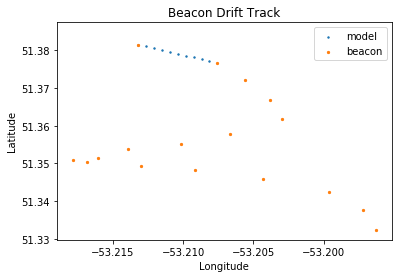

In [136]:
berg1 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

berg1.update_history()

plt.scatter(berg1.history['longitude'], berg1.history['latitude'], s=2, label='model')


plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=5, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

## berg2

In [137]:
indxi = 1
dindx = 1
indxf = 2

ref_berg2 = copy.deepcopy(ref_berg)
ref_berg2.history['time'] = ref_berg2.history['time'][indxi : indxf + 1]
ref_berg2.history['latitude'] = ref_berg2.history['latitude'][indxi : indxf + 1]
ref_berg2.history['longitude'] = ref_berg2.history['longitude'][indxi : indxf + 1]

start_time = ref_berg2.history['time'][0]
end_time = ref_berg2.history['time'][dindx]
start_latitude = berg1.history['latitude'][-1]
start_longitude = berg1.history['longitude'][-1]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index + indxi - 1, start_index + indxf + 1)
time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)
meto = metocean.Metocean((start_time, end_time))

In [138]:
# WARNING: make sure to re-init berg before running minimization

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg2, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.000710827475039926
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.97690798e-05, 1.45506307e-04])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 4
   status: 0
  success: True
        x: array([0., 0.])

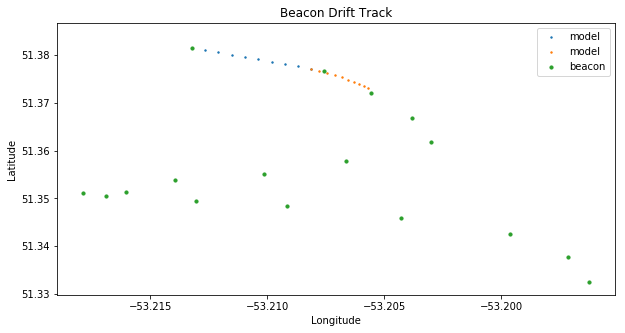

In [144]:
berg2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

berg2.update_history()

fig = plt.figure(figsize=(10,5))

plt.scatter(berg1.history['longitude'], berg1.history['latitude'], s=2,label='model')
plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='model')


plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=10, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

### berg3

In [145]:
indxi = 2
dindx = 1
indxf = 3

ref_berg3 = copy.deepcopy(ref_berg)
ref_berg3.history['time'] = ref_berg3.history['time'][indxi : indxf + 1]
ref_berg3.history['latitude'] = ref_berg3.history['latitude'][indxi : indxf + 1]
ref_berg3.history['longitude'] = ref_berg3.history['longitude'][indxi : indxf + 1]

start_time = ref_berg3.history['time'][0]
end_time = ref_berg3.history['time'][dindx]
start_latitude = berg2.history['latitude'][-1]
start_longitude = berg2.history['longitude'][-1]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index + indxi - 1, start_index + indxf + 1)
time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)
meto = metocean.Metocean((start_time, end_time))

In [152]:
# WARNING: make sure to re-init berg before running minimization

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg3, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.0022581974926803934
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.08039791e-06,  9.70010964e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 5
   status: 0
  success: True
        x: array([1.50883961, 0.        ])

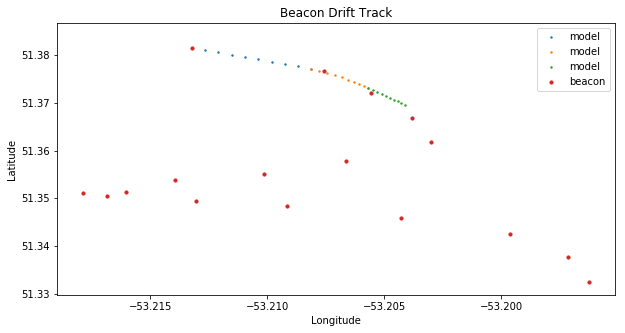

In [153]:
berg3 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

berg3.update_history()

fig = plt.figure(figsize=(10,5))

plt.scatter(berg1.history['longitude'], berg1.history['latitude'], s=2, label='model')
plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='model')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='model')


plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=10, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

## The loop

In [169]:
sub_berg_list = []
sub_ref_berg_list = []

df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

start_time = np.datetime64(df.DataDate_UTC[start_index])
start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

end_time = np.datetime64(df.DataDate_UTC[end_index])
time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)

ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

for i in range(end_index - start_index + 2):
    
    if not df.DataDate_UTC[start_index + i] == df.DataDate_UTC[start_index + i + 1]:
        ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
        ref_berg.latitude = df.Latitude[start_index + i]
        ref_berg.longitude = df.Longitude[start_index + i]
        ref_berg.update_history()

sub_ref_berg = copy.deepcopy(ref_berg)
sub_ref_berg.history['time'] = [sub_ref_berg.history['time'][0]]
sub_ref_berg.history['latitude'] = [sub_ref_berg.history['latitude'][0]]
sub_ref_berg.history['longitude'] = [sub_ref_berg.history['longitude'][0]]

meto = metocean.Metocean((start_time, end_time))
sub_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)
sub_berg.update_history()

In [170]:
for ii in range(len(ref_berg.history['time'])-1):

    start_time = sub_berg.history['time'][-1]
    start_latitude = sub_berg.history['latitude'][-1]
    start_longitude = sub_berg.history['longitude'][-1]
    start_velocity = (sub_berg.eastward_velocity, sub_berg.northward_velocity)

    del sub_ref_berg

    indxi = ii
    dindx = 1
    indxf = ii + 1

    sub_ref_berg = copy.deepcopy(ref_berg)
    sub_ref_berg.history['time'] = sub_ref_berg.history['time'][indxi : indxf + 1]
    sub_ref_berg.history['latitude'] = sub_ref_berg.history['latitude'][indxi : indxf + 1]
    sub_ref_berg.history['longitude'] = sub_ref_berg.history['longitude'][indxi : indxf + 1]

    end_time = sub_ref_berg.history['time'][dindx]
    time_info = (time_step, end_time)

    optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 5), (0, 5)), 
                                   args=(sub_ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                         meto, time_info), callback=callback)
    
    del sub_berg
    
    sub_berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                          meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

    sub_berg.update_history()

    sub_berg_list.append(sub_berg)
    sub_ref_berg_list.append(ref_berg)

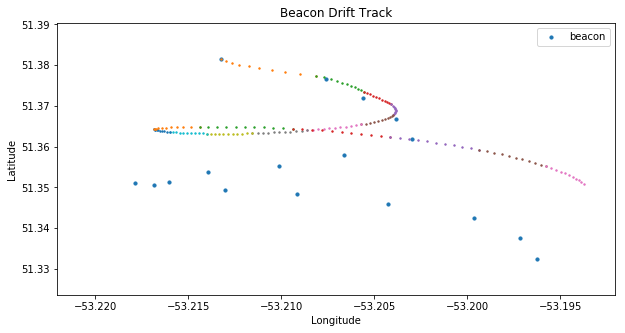

In [171]:
fig = plt.figure(figsize=(10,5))

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=10, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')

for berg in sub_berg_list:
    
    plt.scatter(berg.history['longitude'], berg.history['latitude'], s=2)


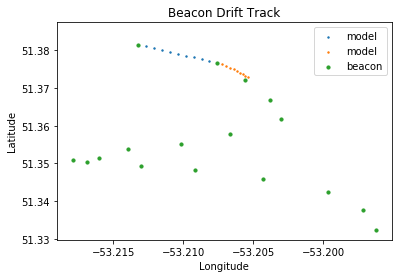

In [114]:
berg2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

berg2.update_history()

plt.scatter(berg1.history['longitude'], berg1.history['latitude'], s=2, label='model')
plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='model')


plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=10, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

In [77]:
from mpl_toolkits.mplot3d import Axes3D

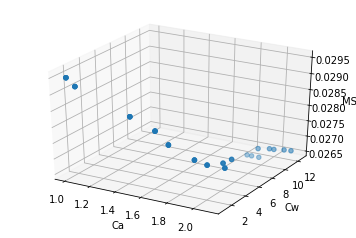

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(callback_Cas), np.array(callback_Cws), np.array(callback_mses))

ax.set_xlabel('Ca')
ax.set_ylabel('Cw')
ax.set_zlabel('MSE')

plt.show()

In [79]:
# WARNING: make sure to re-init berg before running minimization

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.026560046409399265
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.28816182e-06, -4.65634475e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 15
   status: 0
  success: True
        x: array([ 2.05533429, 12.42601852])

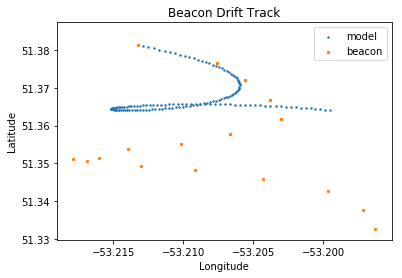

In [82]:
berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

plt.scatter(berg.history['longitude'], berg.history['latitude'], s=2, label='model')
#plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=5, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()